# Problem Statement
Performing an efficient management of budget and securing accuracy are key points when using crowdsourcing. In classification scenarios the crowd sometimes can be noisy and generate a lack of concensus over tasks. The majority of the state-of-art approaches set a fixed number of votes per item and aggregate the votes with some criteria, this produces a reduction in the quality and an increment of costs. For this reason we present a smart detection algorithm which predicts the best decision between stop or continue collecting votes over a task and analyze its efficiency with different experiments.

Formalizing the problem, given a set of items $I$, a set of votes $V$, a classification function $fn$, a classification threshold $th$ and a cost ratio for crowd to expert vote cost $cr$, for each item we want to find the minimum amount of votes needed to take the decision of continue collecting votes or switch to an expert vote. For this we describe a smart stopping algorithm. 

**We define a 3 methods structure**:
- the **classifier** which returns the probability of an item being classified
- the **cost estimator** which returns the estimated cost for each item given the votes
- the **decision function** which returns a boolean decision for each item

# Rationale for the algorithms

### Classifier function

- Input: item votes
- Output: probability IN [0, 1]

### Cost estimator function


- Input: item votes, classification threshold, classification function, cost ratio
- Output: predicted cost
- Logic:
    - Iterate 50 times for converging the results
        - Calculate actual cost for the given votes
        - While (is not classified or is not too expensive)
            - If actual cost is not too expensive
                - Get P(IN) using the classification function
                - If P(IN) > threshold
                    - **Stop because item can be classified**
                - Else
                    - Simulate 1 vote over the item using P(IN)
                    - Increment actual cost
            - Else **stop because the item is too expensive to be classified**

### Decision function



- Input: items, votes, classification_threshold, cost_ratio, classification_function
- Output: Boolean decision over each item, where True = continue and False = stop collecting votes
- Logic:
    - For each item
        - Get P(IN) using the classification function
        - If P(IN) > classification threshold
            - Decision over item = False
        - Else
            - Call **cost estimator function**
                - If cost estimated <= max cost
                    - Decision over item = True
                - Else
                    - Decision over item = False


# Experiments

Here we discuss a few experiments, the objective is to compare the overall crowdsourcing cost and quality in the case where we have a smart stopping algorithm vs 
- the baseline approach where all items receive the same amount of votes
- an approach introduced by Andrew W. Brown and David B. Allison. 2014. Using Crowdsourcing to Evaluate Published Scientific Literature: Methods and Example. Plos One 9, 7 (2014). Where 2 votes are requested and if they disagree ask a third to break the tie

### Experiments Imports

In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd
from helpers.mv_single_binary import majority_voting
from helpers.truth_finder_single import truth_finder_single as truth_finder
import helpers.algorithms_utils as alg_utils
from IPython.display import HTML
#import threading

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

### Hyperparameters for all experiments

In [3]:
#main
cf = majority_voting
#cr = .01 #ratio 1:100 #evaluate multiple crs
base_votes_per_item = 3

#cost estimator
drawing_simulations_amount = 10
expert_cost_increment = 2

#crowd
workers_num = 1000 #fixed number
z = 0 #% cheaters
base_workers_acc = .5
fixed_acc = False
fixed_workers_acc = .9


#ground truth 
items_num = 1000
data_true_percentage = .5

#experiment 
iterations_per_ct = 10
cts = [.5, .6, .7, .8, .9] #classification thresholds

In [4]:
columns = ["Cost mean","Cost Std", "TC mean", "TC std", "Loss mean", "Loss Std", "Recall mean", "Recall Std", "Precision mean", "Precision Std"]
pdColumns = ["Threshold"] + columns

## 1) Experiments without considering workers accuracy for predictions

## 1.1) Smart stop with MV as classification function, where the Expected cost is limited by expert cost.

## 1.1.1) Logic

1. Evalute for each classification threshold in [.5, .75, .8, .85, .9, .95]
2. Iterate 50 times per threshold for converging results doing:
    1. Generate workers accuracy
    2. Generate ground truth values
    3. Generate the base votes for each item
    4. Call the decision function
        1. If we have any item to continue collecting votes:
            1. Collect 1 more vote per item
            2. Call decision function
    5. Classify items using MV
        1. If P(IN) > threshold, classify it as IN
        2. If P(IN) < .3, classify it as OUT
        3. If .3 < P(IN) <= threshold, switch to expert vote
    6. Calculate the metrics

In [5]:
'''
    Input:
        v - votes for item i
        ct - value between 0 and 1 for deciding if prob of data is enough or must continue
        cf - function to calculate how likely is to be classified
        cr - cost ratio between crowd to expert vote [0,1]
    Output:
        (cost_mean, cost_std)
'''
def cost_estimator(v, ct, cf, cr):
    simulated_costs = []
    
    for _ in range(drawing_simulations_amount):
        must_continue = True
        i_item_votes = v.copy()
        while (must_continue):
            classification_prob_in = cf(alg_utils.input_adapter_single(i_item_votes))
            classification_prob_out = 1 - classification_prob_in
            if ((classification_prob_in > ct) or (classification_prob_out > ct)):
                must_continue = False            
                simulated_costs.append(alg_utils.get_crowd_cost(i_item_votes, cr))
            else:
                vote = np.random.binomial(1, classification_prob_in)
                new_index = max(i_item_votes.keys()) + 1
                i_item_votes[new_index] = [vote]
                actual_cost = alg_utils.get_crowd_cost(i_item_votes, cr)
                
                if((actual_cost) >= (1 * expert_cost_increment)):
                    must_continue = False
                    simulated_costs.append(actual_cost)
        #end while      
    #end for
                    
    return (np.mean(simulated_costs),np.std(simulated_costs))

In [6]:
'''
Function to answer: must continue collecting votes over each task?

Input:
items - set of items
votes - set of votes over each item
classification_threshold - value between 0 and 1 for deciding if prob of data is enough or must continue
cost_ratio - ratio of crowd to expert cost, [0,1]
classification_function - function to calculate how likely is to be classified

Output:
    Dictionary with the decision indexed by item_id
        {
            item_id: bool
            ...
            item_n: ...
        }
    Where False = Stop and True=Continue collecting votes
'''
def decision_function(items, votes, ct, cr, cf):       
    results = {i:(((1 - ct) <= cf(alg_utils.input_adapter_single(i_votes)) <= ct)) for i, i_votes in votes.items()}
    
    ids_items_unclassified = [i for i, d in results.items() if d == True]
    #th_items_n = 100
    
    for item_id in ids_items_unclassified:
        item_votes = votes[item_id].copy()
        cost_mean, cost_std = cost_estimator(item_votes, ct, cf, cr)

        if(cost_mean > (1 + (alg_utils.get_crowd_cost(item_votes, cr)))):
            results[item_id] = False
    
    '''
    if (len(ids_items_unclassified) <= th_items_n):
        predict_cost(ids_items_unclassified, results, votes, ct, cf, cr)
    else: 
        threads = []
        ids_items_unclassified_chunks = list(alg_utils.chunks(ids_items_unclassified, th_items_n))
        threads_n = len(ids_items_unclassified_chunks)
        for i in range(threads_n):
            th = threading.Thread(target=predict_cost, args=(ids_items_unclassified_chunks[i], results, votes, ct, cf, cr))
            th.start()
            threads.append(th)

        for th in threads:
            th.join()
    '''
    
    return results
    
def predict_cost(items_ids, results, votes, ct, cf, cr):
    for item_id in items_ids:
        item_votes = votes[item_id].copy()
        cost_mean, cost_std = cost_estimator(item_votes, ct, cf, cr)

        if(cost_mean > (1 + (alg_utils.get_crowd_cost(item_votes, cr)))):
            results[item_id] = False

In [7]:
def generate_votes_1(params, items_num, ct, gt):
    total_votes = {}
    
    #base votes
    for i in range(items_num):
        total_votes[i] = {}
        for k in range(params['votes_per_item']):
            worker_id, vote = alg_utils.get_worker_vote(params['workers_accuracy'], i, gt, total_votes)

            total_votes[i][worker_id] = [vote]
            
    #evaluate votes
    results = decision_function(items_num, total_votes, ct, params['cost_ratio'], 
                                                   params['classification_fn'])
    
    #Check if must continue collecting votes
    items_predicted_classified = alg_utils.get_items_predicted_classified(results)
    must_get_more_votes = len(items_predicted_classified) > 0
     
    while(must_get_more_votes):
        total_votes_aux = {}
        for i, v in items_predicted_classified.items():           
            worker_id, vote = alg_utils.get_worker_vote(params['workers_accuracy'], i, gt, total_votes)
            
            total_votes[i][worker_id] = [vote]
            
            total_votes_aux[i] = total_votes[i]
        #end for
        results = decision_function(len(total_votes_aux), total_votes_aux, ct, params['cost_ratio'], 
                                                   params['classification_fn'])

        #Stop when there are no more items that can be classified
        items_predicted_classified = alg_utils.get_items_predicted_classified(results)
        must_get_more_votes = len(items_predicted_classified) > 0
    #end while
    
    items_classification = alg_utils.classify_items_mv(total_votes, gt, params['classification_fn'], ct)

    return [items_classification, total_votes]

In [8]:
def run_experiment_1(cr):
    main_results = []

    for ct in tqdm(cts):
        ct = round(ct, 2) #limit to two decimals
        crowd_cost = []
        total_cost = []
        items_classified_in = []
        items_classified_out = []
        ct_loss = []
        ct_recall = []
        ct_precision = []
        ct_classified_amount = []
        ct_unclassified_amount = []

        for _ in range(iterations_per_ct):
            workers_accuracy = alg_utils.simulate_workers(workers_num, z, fixed_acc, fixed_workers_acc, base_workers_acc)
            
            params = {
                'workers_accuracy': workers_accuracy,
                'workers_num': workers_num,
                'items_num': items_num,
                'cost_ratio': cr,
                'votes_per_item': base_votes_per_item,
                'classification_fn': cf
            }
            
            ground_truth = alg_utils.generate_gold_data(items_num, data_true_percentage)
    
            ct_i_results = generate_votes_1(params, items_num, ct, ground_truth)

            items_classification = ct_i_results[0]
            total_votes = ct_i_results[1]
            
            classified_amount, unclassified_amount, ct_i_crowd_cost, ct_i_total_cost = alg_utils.get_total_cost(total_votes, cr, cf, ct, False)
            
            ct_classified_amount.append(classified_amount)
            ct_unclassified_amount.append(unclassified_amount)
            crowd_cost.append(ct_i_crowd_cost)
            total_cost.append(ct_i_total_cost)

            loss,  recall, precision = alg_utils.Metrics.compute_metrics(items_classification, ground_truth)
            ct_loss.append(loss)
            ct_recall.append(recall)
            ct_precision.append(precision)
        #end for iterations

        main_results.append(
            [ct, 
             round(np.mean(crowd_cost), 3), 
             round(np.std(crowd_cost), 3),
             round(np.mean(total_cost), 3),
             round(np.std(total_cost), 3),
             round(np.mean(ct_loss), 3),
             round(np.std(ct_loss), 3),
             round(np.mean(ct_recall), 3),
             round(np.std(ct_recall), 3),
             round(np.mean(ct_precision), 3),
             round(np.std(ct_precision), 3)
            ])
    #end for thresholds

    return main_results

## 1.1.2) Run experiment 1 and see the results 

In [9]:
#alg_utils.print_hyperparameters(cf, cr,base_votes_per_item, drawing_simulations_amount, expert_cost_increment, workers_num, z, fixed_acc, base_workers_acc, fixed_workers_acc, items_num, data_true_percentage, iterations_per_ct, cts)
#results_mv = run_experiment_1()

#table    
#pd.DataFrame(results_mv, columns=pdColumns).to_csv('results/smart_stop_mv_not_expert.csv', index=False)
pd.DataFrame(results_mv, columns=pdColumns)

NameError: name 'cr' is not defined

## Plot the difference between # iterations per ct and # drawings per item cost estimation:
**Comparison:**
- 10/10
- 50/50

**Other params:**
- balanced data 50/50
- cr: 0.01
- crowd acc > .5


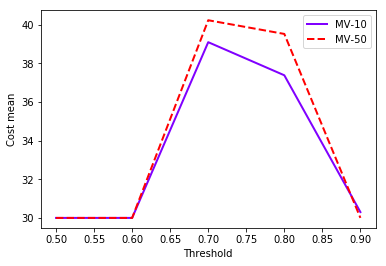

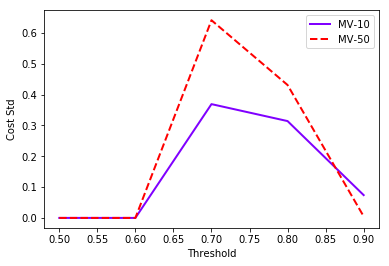

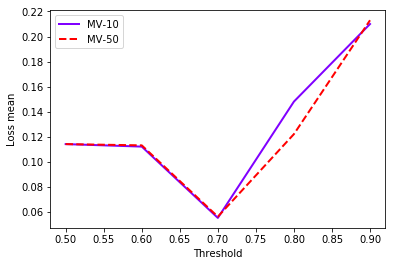

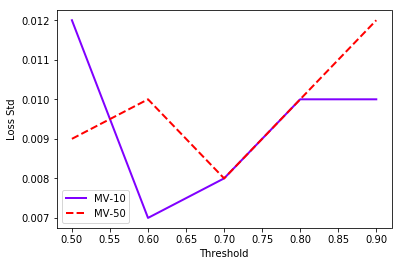

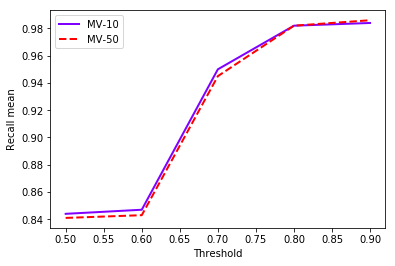

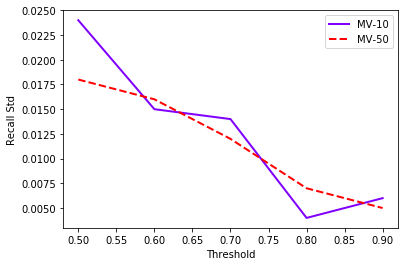

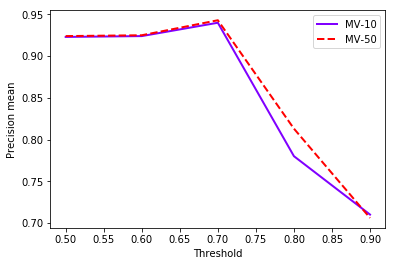

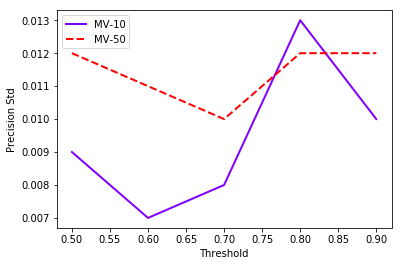

In [13]:
mv_50 = pd.read_csv('./results/smart_stop_mv_not_expert_i50_d50_cr01.csv')
mv_10 = pd.read_csv('./results/smart_stop_mv_not_expert_i10_d10_cr01.csv')

print_columns = ["Cost mean","Cost Std", "Loss mean", "Loss Std", "Recall mean", "Recall Std", "Precision mean", "Precision Std"]
    
for column in print_columns:
    alg_utils.plot_results(cts, 
                           {
                               "MV-10": mv_10[column],
                               "MV-50": mv_50[column],
                           }, 
                           "Threshold", 
                           column)

## 1.2) MV with fixed number of votes per item

In this experiment we use the baseline approach of majority voting with a fixed number of votes per item and a classification threshold of .5

## 1.2.1) Logic

1. Iterate 50 times for converging results where:
    1. Generate workers accuracy
    2. Generate ground truth values
    3. Generate a fixed number of votes for each item
    4. Classify items using MV
    5. Calculate the metrics

In [24]:
def generate_votes_2(params, items_num, ct, gt):
    total_votes = {}

    #base votes
    for i in range(items_num):
        total_votes[i] = {}
        for k in range(params['votes_per_item']):
            worker_id, vote = alg_utils.get_worker_vote(params['workers_accuracy'], i, gt, total_votes)

            total_votes[i][worker_id] = [vote]

    items_classification = alg_utils.classify_items_mv(total_votes, gt, params['classification_fn'], ct)
    
    return [items_classification, total_votes]

In [25]:
def run_experiment_2():
    main_results = []

    for ct in tqdm(cts):
        ct = round(ct, 2) #limit to two decimals
        crowd_cost = []
        total_cost = []
        items_classified_in = []
        items_classified_out = []
        ct_loss = []
        ct_recall = []
        ct_precision = []
        ct_classified_amount = []
        ct_unclassified_amount = []

        for _ in range(iterations_per_ct):
            workers_accuracy = alg_utils.simulate_workers(workers_num, z, fixed_acc, fixed_workers_acc, base_workers_acc)
            
            params = {
                'workers_accuracy': workers_accuracy,
                'workers_num': workers_num,
                'items_num': items_num,
                'cost_ratio': cr,
                'votes_per_item': base_votes_per_item,
                'classification_fn': cf
            }
                
            ground_truth = alg_utils.generate_gold_data(items_num, data_true_percentage)

            ct_i_results = generate_votes_2(params, items_num, ct, ground_truth)

            items_classification = ct_i_results[0]
            total_votes = ct_i_results[1]

            loss,  recall, precision = alg_utils.Metrics.compute_metrics(items_classification, ground_truth)
            ct_loss.append(loss)
            ct_recall.append(recall)
            ct_precision.append(precision)
            
            ct_i_crowd_cost = sum([len(v) for i, v in total_votes.items()]) * cr
            ct_i_total_cost = ct_i_crowd_cost
       
            crowd_cost.append(ct_i_crowd_cost)
            total_cost.append(ct_i_total_cost)
        #end for iterations
        
        main_results.append(
            [ct,
             round(np.mean(crowd_cost), 3), 
             round(np.std(crowd_cost), 3),
             round(np.mean(total_cost), 3),
             round(np.std(total_cost), 3),
             round(np.mean(ct_loss), 3),
             round(np.std(ct_loss), 3),
             round(np.mean(ct_recall), 3),
             round(np.std(ct_recall), 3),
             round(np.mean(ct_precision), 3),
             round(np.std(ct_precision), 3)
            ])
    #end for thresholds

    return main_results

## 1.2.2) Run experiment 2 and see the results

In [30]:
alg_utils.print_hyperparameters(cf, cr,base_votes_per_item, drawing_simulations_amount, expert_cost_increment, workers_num, z, fixed_acc, base_workers_acc, fixed_workers_acc, items_num, data_true_percentage, iterations_per_ct, cts)
results_mv_baseline = run_experiment_2()

#table    
pd.DataFrame(results_mv_baseline, columns=pdColumns).to_csv('results/baseline_mv_it10_v3_cr01.csv', index=False)
pd.DataFrame(results_mv_baseline, columns=pdColumns)


  0%|          | 0/5 [00:00<?, ?it/s]


        Hyparparameters:
            - Classification
                * Classification function: majority_voting
                * Cost ratio: 0.01
            - Classification thresholds:
                * 0    0.5
1    0.6
2    0.7
3    0.8
4    0.9
Name: Threshold, dtype: float64
            - Items
                * Amount: 1000 
                * Ground true percentage: 0.5
            - MV votes:
                * Base votes per item: 3
            - Workers
                * Amount of workers: 1000
                * Cheaters percentage: 0
                * If not fixed, workers accuracy > 0.5 
                * Workers fixed accuracy? False
                * Fixed number: 0.9
            - Cost estimator fn
                * Cost estimator drawing number: 10
                * Expert cost increment: 2
    



100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


,Threshold,Cost mean,Cost Std,TC mean,TC std,Loss mean,Loss Std,Recall mean,Recall Std,Precision mean,Precision Std
0,0.5,30.0,0.0,30.0,0.0,0.109,0.011,0.844,0.021,0.931,0.011
1,0.6,30.0,0.0,30.0,0.0,0.118,0.007,0.832,0.010,0.925,0.011
2,0.7,30.0,0.0,30.0,0.0,0.214,0.010,0.984,0.006,0.704,0.008
3,0.8,30.0,0.0,30.0,0.0,0.205,0.011,0.984,0.004,0.715,0.011
4,0.9,30.0,0.0,30.0,0.0,0.213,0.012,0.985,0.004,0.706,0.012


## 1.3) Two votes first and if disagree one more to break the tie

In this experiment we collect 2 votes per item and a third one if they disagree.

## 1.3.1) Logic

1. Iterate 50 times for converging results where:
    1. Generate workers accuracy
    2. Generate ground truth values
    3. Generate 2 votes for each item
    4. Evalutes the votes:
        1. If votes agree:
            1. Jump to next step
        2. If votes disagree:
            1. Get 1 more vote 
    4. Classify items using MV
    5. Calculate the metrics

In [27]:
def generate_votes_3(params, items_num, ct, gt):
    total_votes = {}

    #base votes
    for i in range(items_num):
        total_votes[i] = {}
        for k in range(2):
            worker_id, vote = alg_utils.get_worker_vote(params['workers_accuracy'], i, gt, total_votes)

            total_votes[i][worker_id] = [vote]
            
        #if disagree get 1 more vote
        votes_disagree = sum([v[0] for i,v in total_votes[i].items()]) == 1
        if(votes_disagree):
            worker_id, vote = alg_utils.get_worker_vote(params['workers_accuracy'], i, gt, total_votes)

            total_votes[i][worker_id] = [vote]

    items_classification = alg_utils.classify_items_mv(total_votes, gt, params['classification_fn'], ct)
    
    return [items_classification, total_votes]

In [28]:
def run_experiment_3():
    main_results = []

    for ct in tqdm(cts):
        ct = round(ct, 2) #limit to two decimals
        crowd_cost = []
        total_cost = []
        items_classified_in = []
        items_classified_out = []
        ct_loss = []
        ct_recall = []
        ct_precision = []
        ct_classified_amount = []
        ct_unclassified_amount = []

        for _ in range(iterations_per_ct):
            workers_accuracy = alg_utils.simulate_workers(workers_num, z, fixed_acc, fixed_workers_acc, base_workers_acc)
            
            params = {
                'workers_accuracy': workers_accuracy,
                'workers_num': workers_num,
                'items_num': items_num,
                'cost_ratio': cr,
                'votes_per_item': base_votes_per_item,
                'classification_fn': cf
            }
                
            ground_truth = alg_utils.generate_gold_data(items_num, data_true_percentage)

            ct_i_results = generate_votes_3(params, items_num, ct, ground_truth)

            items_classification = ct_i_results[0]
            total_votes = ct_i_results[1]

            loss,  recall, precision = alg_utils.Metrics.compute_metrics(items_classification, ground_truth)
            ct_loss.append(loss)
            ct_recall.append(recall)
            ct_precision.append(precision)
            
            ct_i_crowd_cost = sum([len(v) for i, v in total_votes.items()]) * cr
            ct_i_total_cost = ct_i_crowd_cost
       
            crowd_cost.append(ct_i_crowd_cost)
            total_cost.append(ct_i_total_cost)
        #end for iterations
        
        main_results.append(
            [ct,
             round(np.mean(crowd_cost), 3), 
             round(np.std(crowd_cost), 3),
             round(np.mean(total_cost), 3),
             round(np.std(total_cost), 3),
             round(np.mean(ct_loss), 3),
             round(np.std(ct_loss), 3),
             round(np.mean(ct_recall), 3),
             round(np.std(ct_recall), 3),
             round(np.mean(ct_precision), 3),
             round(np.std(ct_precision), 3)
            ])
    #end for thresholds

    return main_results

## 3.2) Run experiment 3 and see the results

In [31]:
alg_utils.print_hyperparameters(cf, cr,base_votes_per_item, drawing_simulations_amount, expert_cost_increment, workers_num, z, fixed_acc, base_workers_acc, fixed_workers_acc, items_num, data_true_percentage, iterations_per_ct, cts)
results_mv_break_tie = run_experiment_3()

#table    
pd.DataFrame(results_mv_break_tie, columns=pdColumns).to_csv('results/mv_break_tie_it10_cr01.csv', index=False)
pd.DataFrame(results_mv_break_tie, columns=pdColumns)


  0%|          | 0/5 [00:00<?, ?it/s]


        Hyparparameters:
            - Classification
                * Classification function: majority_voting
                * Cost ratio: 0.01
            - Classification thresholds:
                * 0    0.5
1    0.6
2    0.7
3    0.8
4    0.9
Name: Threshold, dtype: float64
            - Items
                * Amount: 1000 
                * Ground true percentage: 0.5
            - MV votes:
                * Base votes per item: 3
            - Workers
                * Amount of workers: 1000
                * Cheaters percentage: 0
                * If not fixed, workers accuracy > 0.5 
                * Workers fixed accuracy? False
                * Fixed number: 0.9
            - Cost estimator fn
                * Cost estimator drawing number: 10
                * Expert cost increment: 2
    



100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


,Threshold,Cost mean,Cost Std,TC mean,TC std,Loss mean,Loss Std,Recall mean,Recall Std,Precision mean,Precision Std
0,0.5,23.077,0.094,23.077,0.094,0.111,0.011,0.847,0.017,0.925,0.012
1,0.6,23.241,0.089,23.241,0.089,0.109,0.010,0.850,0.013,0.927,0.010
2,0.7,23.251,0.165,23.251,0.165,0.177,0.015,0.942,0.009,0.761,0.016
3,0.8,23.217,0.107,23.217,0.107,0.181,0.012,0.941,0.008,0.757,0.014
4,0.9,23.228,0.176,23.228,0.176,0.188,0.012,0.931,0.005,0.752,0.015


# 3.3) MV results evaluation

## 3.3.1) Quality and cost evaluation between mv smart, mv baseline and Brown&Allison

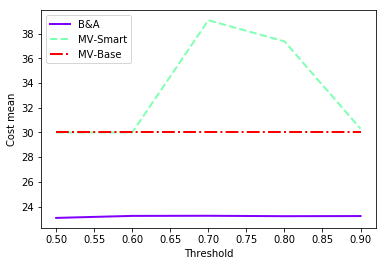

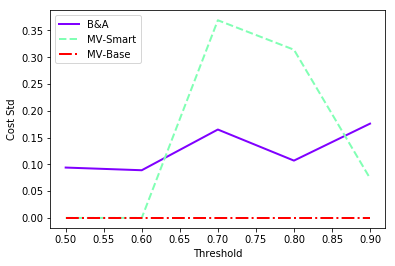

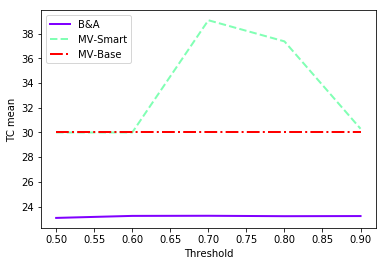

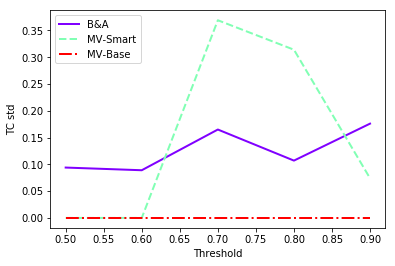

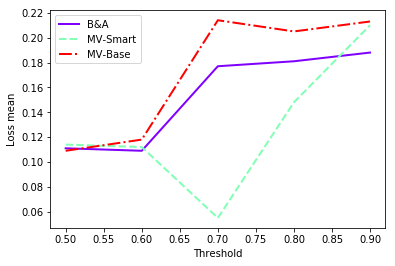

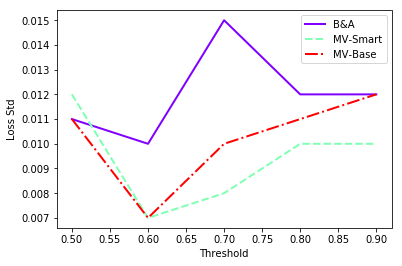

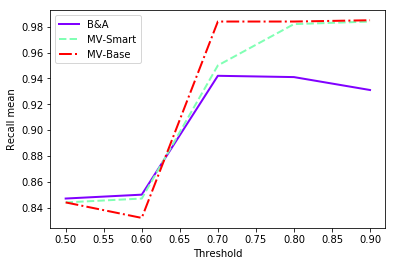

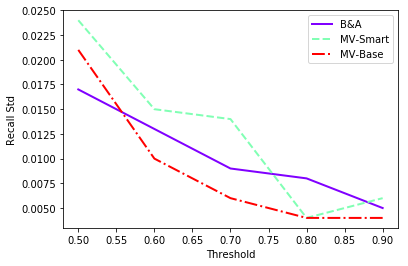

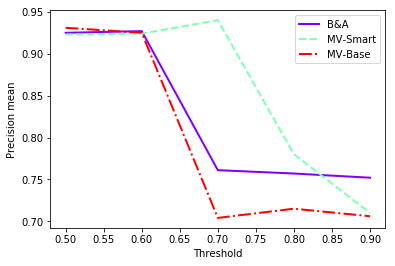

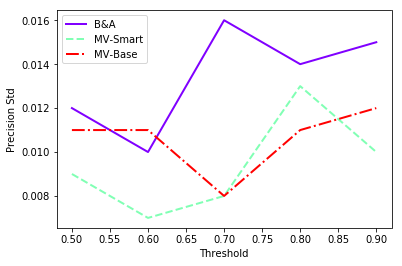

In [33]:
results_mv_baseline = pd.read_csv('./results/baseline_mv_it10_v3_cr01.csv')
results_mv = pd.read_csv('./results/smart_stop_mv_not_expert_i10_d10_cr01.csv')
results_mv_break_tie = pd.read_csv('./results/mv_break_tie_it10_cr01.csv')

cts = results_mv_baseline['Threshold']
    
for column in columns:
    alg_utils.plot_results(cts, 
                           {
                               "B&A": results_mv_break_tie[column],
                               "MV-Smart": results_mv[column],
                               "MV-Base": results_mv_baseline[column]
                           }, 
                           "Threshold", 
                           column)

## 3.3.2) MV Cost Ratio Evaluation

In [13]:
crs = np.arange(.01, .11, .01) #from .02 to .1
for cr in crs:
    cr = round(cr,2)
    #results_mv = run_experiment_1(cr)
    cr_str = str(round(cr-int(cr), 2))[2:]

    pd.DataFrame(results_mv, columns=pdColumns).to_csv(f'results/smart_stop_mv_not_expert_i10_d10_cr{cr_str}.csv', index=False)


100%|██████████| 5/5 [00:46<00:00, 10.39s/it]

100%|██████████| 5/5 [00:47<00:00, 10.36s/it]

100%|██████████| 5/5 [00:41<00:00,  8.91s/it]


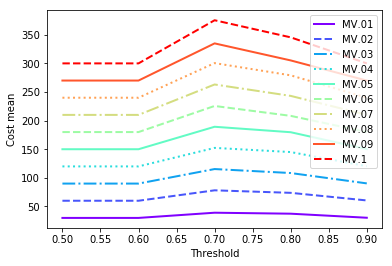

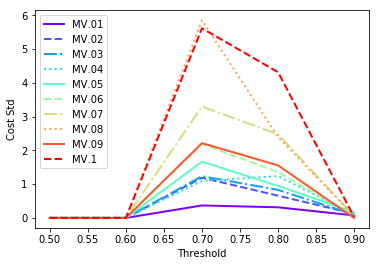

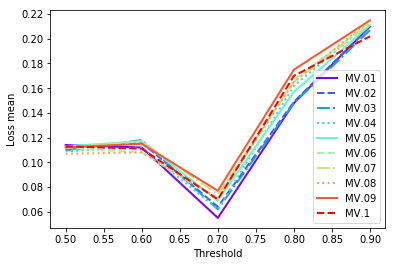

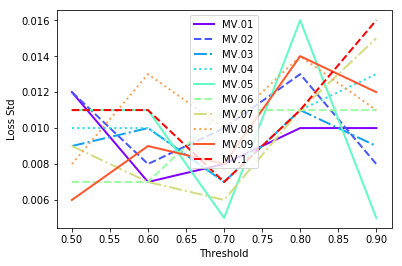

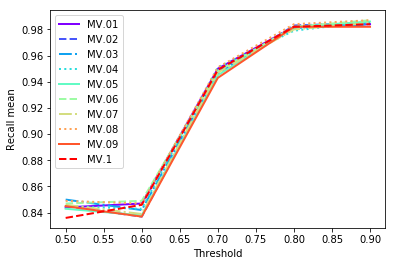

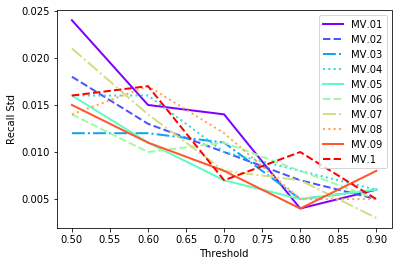

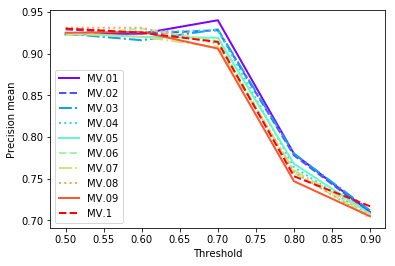

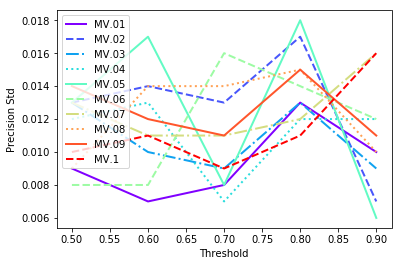

In [14]:
mv_01 = pd.read_csv('./results/smart_stop_mv_not_expert_i10_d10_cr01.csv')
mv_02 = pd.read_csv('./results/smart_stop_mv_not_expert_i10_d10_cr02.csv')
mv_03 = pd.read_csv('./results/smart_stop_mv_not_expert_i10_d10_cr03.csv')
mv_04 = pd.read_csv('./results/smart_stop_mv_not_expert_i10_d10_cr04.csv')
mv_05 = pd.read_csv('./results/smart_stop_mv_not_expert_i10_d10_cr05.csv')
mv_06 = pd.read_csv('./results/smart_stop_mv_not_expert_i10_d10_cr06.csv')
mv_07 = pd.read_csv('./results/smart_stop_mv_not_expert_i10_d10_cr07.csv')
mv_08 = pd.read_csv('./results/smart_stop_mv_not_expert_i10_d10_cr08.csv')
mv_09 = pd.read_csv('./results/smart_stop_mv_not_expert_i10_d10_cr09.csv')
mv_1 = pd.read_csv('./results/smart_stop_mv_not_expert_i10_d10_cr1.csv')


print_columns = ["Cost mean","Cost Std", "Loss mean", "Loss Std", "Recall mean", "Recall Std", "Precision mean", "Precision Std"]
    
for column in print_columns:
    alg_utils.plot_results(cts, 
                           {
                               "MV.01": mv_01[column],
                               "MV.02": mv_02[column],
                               "MV.03": mv_03[column],
                               "MV.04": mv_04[column],
                               "MV.05": mv_05[column],
                               "MV.06": mv_06[column],
                               "MV.07": mv_07[column],
                               "MV.08": mv_08[column],
                               "MV.09": mv_09[column],
                               "MV.1": mv_1[column],
                           }, 
                           "Threshold", 
                           column)

## 2) Experiments using Expectation Maximization

In [15]:
cf = truth_finder
base_workers_acc = .5

In [16]:
alg_utils.print_hyperparameters(cf, cr,base_votes_per_item, drawing_simulations_amount, expert_cost_increment, workers_num, z, fixed_acc, base_workers_acc, fixed_workers_acc, items_num, data_true_percentage, iterations_per_ct, cts)
results_truth_finder = run_experiment_1()

#table    
#pd.DataFrame(results_truth_finder, columns=pdColumns).to_csv('results/smart_stop_truth_finder_not_expert.csv', index=False)
pd.DataFrame(results_truth_finder, columns=pdColumns)

  0%|          | 0/5 [00:00<?, ?it/s]


        Hyparparameters:
            - Classification
                * Classification function: truth_finder_single
                * Cost ratio: 0.01
            - Classification thresholds:
                * [0.5, 0.8, 0.85, 0.9, 0.95]
            - Items
                * Amount: 100 
                * Ground true percentage: 0.5
            - MV votes:
                * Base votes per item: 3
            - Workers
                * Amount of workers: 1000
                * Cheaters percentage: 0
                * If not fixed, workers accuracy > 0.5 
                * Workers fixed accuracy? False
                * Fixed number: 0.9
            - Cost estimator fn
                * Cost estimator drawing number: 50
                * Expert cost increment: 2
    


100%|██████████| 5/5 [00:17<00:00,  3.52s/it]


,Threshold,Cost mean,Cost Std,TC mean,TC std,Loss mean,Loss Std,Recall mean,Recall Std,Precision mean,Precision Std
0,0.50,3.0,0.0,3.0,0.0,0.119,0.031,0.825,0.053,0.929,0.032
1,0.80,3.0,0.0,3.0,0.0,0.113,0.033,0.845,0.051,0.924,0.035
2,0.85,3.0,0.0,3.0,0.0,0.106,0.027,0.848,0.046,0.934,0.029
3,0.90,3.0,0.0,3.0,0.0,0.115,0.036,0.840,0.063,0.925,0.037
4,0.95,3.0,0.0,3.0,0.0,0.109,0.031,0.849,0.049,0.927,0.035


## Results comparison MV against EM

In [34]:
'''
results_mv_baseline = pd.read_csv('./results/baseline_mv.csv')
results_mv = pd.read_csv('./results/smart_stop_mv_not_expert.csv')
results_mv_break_tie = pd.read_csv('./results/mv_break_tie.csv')
results_tf = pd.read_csv('./results/smart_stop_truth_finder_not_expert.csv')

cts = results_mv_baseline['Threshold']
    
for column in columns:
    alg_utils.plot_results(cts, 
                           {
                               "B&A": results_mv_break_tie[column],
                               "MV-Smart": results_mv[column],
                               "MV-Base": results_mv_baseline[column],
                               "TF-Smart": results_tf[column]
                           }, 
                           "Threshold", 
                           column)
'''

'\nresults_mv_baseline = pd.read_csv(\'./results/baseline_mv.csv\')\nresults_mv = pd.read_csv(\'./results/smart_stop_mv_not_expert.csv\')\nresults_mv_break_tie = pd.read_csv(\'./results/mv_break_tie.csv\')\nresults_tf = pd.read_csv(\'./results/smart_stop_truth_finder_not_expert.csv\')\n\ncts = results_mv_baseline[\'Threshold\']\n    \nfor column in columns:\n    alg_utils.plot_results(cts, \n                           {\n                               "B&A": results_mv_break_tie[column],\n                               "MV-Smart": results_mv[column],\n                               "MV-Base": results_mv_baseline[column],\n                               "TF-Smart": results_tf[column]\n                           }, \n                           "Threshold", \n                           column)\n'